# Decision Tree Classification

This data set is made available by the Center for Clinical and Translational Research, Virginia Commonwealth University. It contains data about 10 years of clinical care at 130 US Hospitals. Each row represents a single patient. The columns include the characteristics of deidentified diabetes patients. Binary classification task: predict whether a diabetes patient is readmitted to the hospital within 30 days of their discharge (1=Yes, 0=No). This is an important performance metric for hospitals as they try to minimize these types of readmissions.

## Goal

Use the **healthcare.csv** data set and build a model to predict **readmitted**. 

# Read and Prepare the Data:

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)

In [2]:
healthcare = pd.read_csv("healthcare.csv")
healthcare.head()

,patient_id,race,gender,age,admission_type,discharge_disposition,admission_source,time_in_hospital,payer_code,medical_specialty,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed,readmitted
0,45286812,Caucasian,Female,70-80,6,1,7,1,NaN,NaN,...,786,401,244,4,None,None,No,No,No,0
1,58787946,Caucasian,Female,30-40,3,1,1,1,PO,NaN,...,644,250.01,NaN,2,None,None,No,No,No,1
2,27857475,Caucasian,Female,70-80,5,6,17,4,MC,NaN,...,584,276,276,9,Norm,None,Up,Ch,Yes,0
3,23912577,Caucasian,Female,60-70,5,6,17,2,NaN,Nephrology,...,578,403,273,6,>300,None,Up,Ch,Yes,1
4,24772005,AfricanAmerican,Male,40-50,1,1,7,2,BC,Emergency/Trauma,...,250.12,276,V58,5,None,None,Up,Ch,Yes,0


In [3]:
# Drop ID column
healthcare = healthcare.drop(['patient_id'], axis=1)

### Split into Train and Test

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(healthcare, test_size=0.3)

In [5]:
# Check for missing values
train.isna().sum()

race                      126
gender                      0
age                         0
admission_type              0
discharge_disposition       0
admission_source            0
time_in_hospital            0
payer_code               2621
medical_specialty        3205
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      1
diag_2                     17
diag_3                     77
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
dtype: int64

In [6]:
test.isna().sum()

race                       54
gender                      0
age                         0
admission_type              0
discharge_disposition       0
admission_source            0
time_in_hospital            0
payer_code               1117
medical_specialty        1393
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      2
diag_2                      4
diag_3                     30
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
dtype: int64

### Separate the target variable

In [7]:
train_y = train[['readmitted']]
test_y = test[['readmitted']]

train_inputs = train.drop(['readmitted'], axis=1)
test_inputs = test.drop(['readmitted'], axis=1)

### Identify Numeric/Categorical columns

In [8]:
train_inputs.dtypes

race                     object
gender                   object
age                      object
admission_type            int64
discharge_disposition     int64
admission_source          int64
time_in_hospital          int64
payer_code               object
medical_specialty        object
num_lab_procedures        int64
num_procedures            int64
num_medications           int64
number_outpatient         int64
number_emergency          int64
number_inpatient          int64
diag_1                   object
diag_2                   object
diag_3                   object
number_diagnoses          int64
max_glu_serum            object
A1Cresult                object
insulin                  object
change                   object
diabetesMed              object
dtype: object

In [9]:
# Identify the categorical columns
categorical_columns = train_inputs[['A1Cresult','admission_source','admission_type','age','change','diabetesMed',
                                    'diag_1','diag_2','diag_3','discharge_disposition','gender','insulin','max_glu_serum',
                                    'medical_specialty','payer_code','race']].columns
categorical_columns

Index(['A1Cresult', 'admission_source', 'admission_type', 'age', 'change',
       'diabetesMed', 'diag_1', 'diag_2', 'diag_3', 'discharge_disposition',
       'gender', 'insulin', 'max_glu_serum', 'medical_specialty', 'payer_code',
       'race'],
      dtype='object')

In [10]:
# Identify the categorical columns
numeric_columns  = train_inputs[['num_lab_procedures','num_medications','num_procedures','number_diagnoses',
                                    'number_emergency','number_inpatient','number_outpatient','time_in_hospital']].columns
numeric_columns

Index(['num_lab_procedures', 'num_medications', 'num_procedures',
       'number_diagnoses', 'number_emergency', 'number_inpatient',
       'number_outpatient', 'time_in_hospital'],
      dtype='object')

### Pipeline

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [12]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [13]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)])

### Transform Train and Test

In [14]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)
train_x.shape

(6416, 1356)

In [15]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)
test_x.shape

(2750, 1356)

# Determine Baseline Accuracy

In [16]:
# Find the majority class:
train_y['readmitted'].value_counts()

0    3428
1    2988
Name: readmitted, dtype: int64

In [17]:
#Find the percentage of the majority class:
train_y['readmitted'].value_counts()/len(train_y)

0    0.534289
1    0.465711
Name: readmitted, dtype: float64

Baseline accuracy is 53.4%

# Decision Tree Model 1:

In [18]:
from sklearn.tree import DecisionTreeClassifier 

tree_clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=5)

tree_clf.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Accuracy

In [19]:
from sklearn.metrics import accuracy_score

#Train accuracy:
train_y_pred = tree_clf.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.6265586034912718


In [20]:
#Test accuracy:
test_y_pred = tree_clf.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.6130909090909091


### Classification Matrix/Report

In [21]:
from sklearn.metrics import confusion_matrix

#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[1091,  366],
       [ 698,  595]], dtype=int64)

In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_y, test_y_pred))

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      1457
           1       0.62      0.46      0.53      1293

    accuracy                           0.61      2750
   macro avg       0.61      0.60      0.60      2750
weighted avg       0.61      0.61      0.60      2750



### Tree Plot

In [69]:
import pydotplus
from sklearn.tree import export_graphviz 
from IPython.display import Image

export_graphviz(tree_clf,  
                out_file='tree.dot',
                #feature_names=train_x.columns.values, 
                #class_names=np.unique(train_y), 
                rounded=True, filled=True)

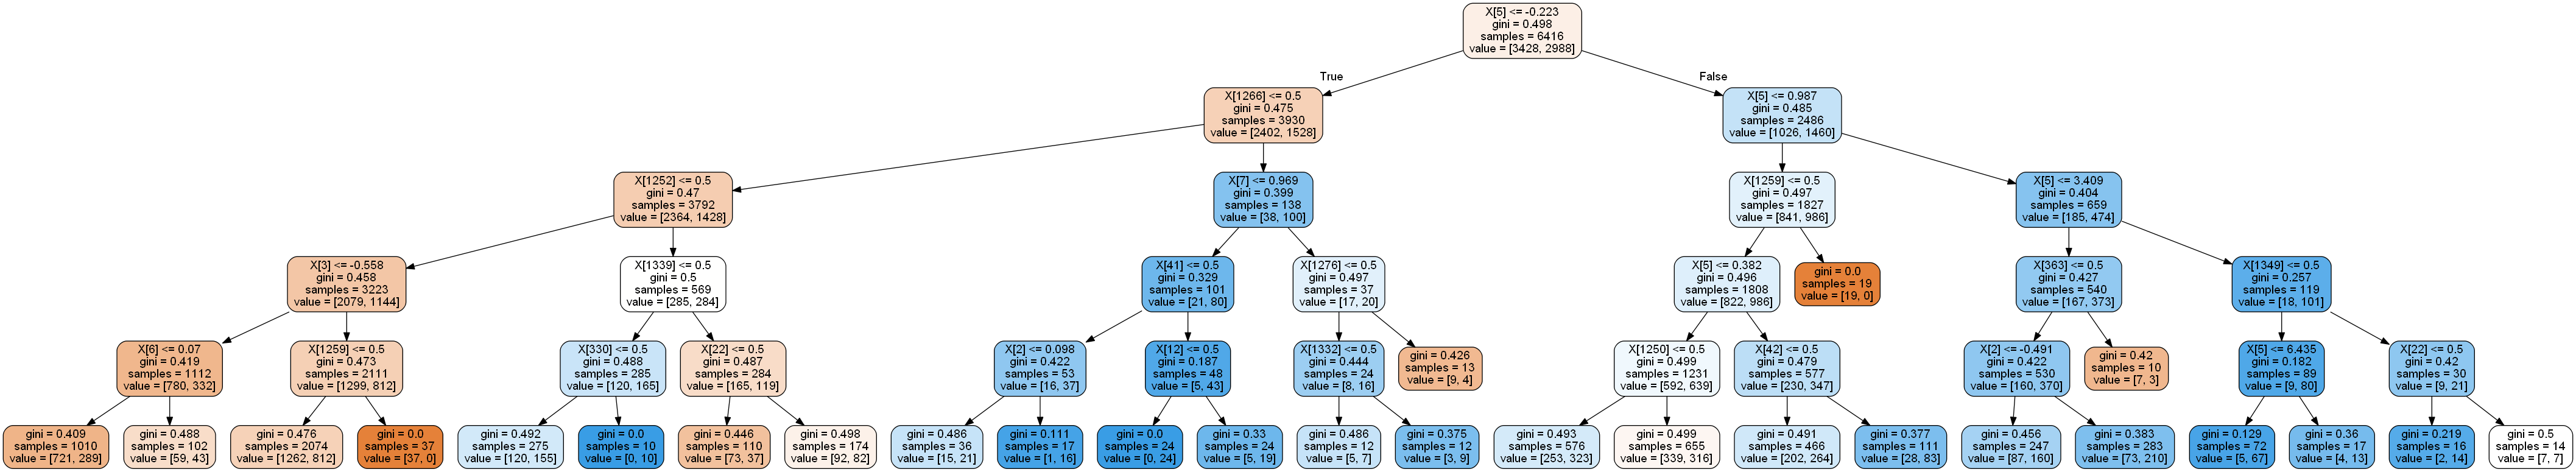

In [24]:
pydot_graph = pydotplus.graph_from_dot_file("tree.dot")

Image(pydot_graph.create_png())

The tree with min_samples_leaf=10, max_depth=5 achieved 61.3% accuracy with minimal overfitting.

# Decision Tree Model 2 - Grid Search

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {'max_depth': randint(low=4, high=20), 
              'min_samples_leaf': randint(low=4, high=20)}

tree_gs = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, 
                             n_iter=50, cv=5, verbose=1,
                             scoring='accuracy',
                             return_train_score=True)

tree_gs.fit(train_x, train_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   28.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [57]:
tree_gs.cv_results_

{'mean_fit_time': array([0.14857669, 0.14822302, 0.09149137, 0.10912743, 0.14931812,
        0.16554971, 0.10794115, 0.16120877, 0.04793615, 0.15481167,
        0.02478447, 0.14111538, 0.17220669, 0.134519  , 0.03177829,
        0.0725832 , 0.02330871, 0.09194551, 0.0645649 , 0.15262599,
        0.14522104, 0.08255424, 0.16654863, 0.11832733, 0.11134057,
        0.13843088, 0.08107419, 0.15530734, 0.09015002, 0.02978201,
        0.16446395, 0.04928918, 0.09134693, 0.04697204, 0.1052752 ,
        0.10854068, 0.13758831, 0.13315639, 0.14211354, 0.13632131,
        0.09894257, 0.11055465, 0.16241398, 0.16682982, 0.02239027,
        0.16383433, 0.13472619, 0.08537412, 0.11447754, 0.06815782]),
 'std_fit_time': array([0.01452441, 0.01744402, 0.00770475, 0.01216761, 0.0223356 ,
        0.01524297, 0.01033878, 0.03786225, 0.00142261, 0.01364418,
        0.00116661, 0.01500413, 0.02035993, 0.00523381, 0.00132115,
        0.00431876, 0.00190466, 0.00811584, 0.00790922, 0.01827571,
        0.035

In [58]:
#Find the best parameter set
tree_gs.best_params_

{'max_depth': 4, 'min_samples_leaf': 9}

In [59]:
tree_gs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Accuracy

In [60]:
#Train accuracy:
train_y_pred = tree_gs.best_estimator_.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.6229738154613467


In [61]:
#Test accuracy:
test_y_pred = tree_gs.best_estimator_.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.6101818181818182


In [62]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[929, 528],
       [544, 749]], dtype=int64)

### Tree Plot

In [64]:
export_graphviz(tree_gs.best_estimator_,  
                out_file='tree.dot2',
                #feature_names=train_x.columns.values, 
                #class_names=np.unique(train_y), 
                rounded=True, filled=True)

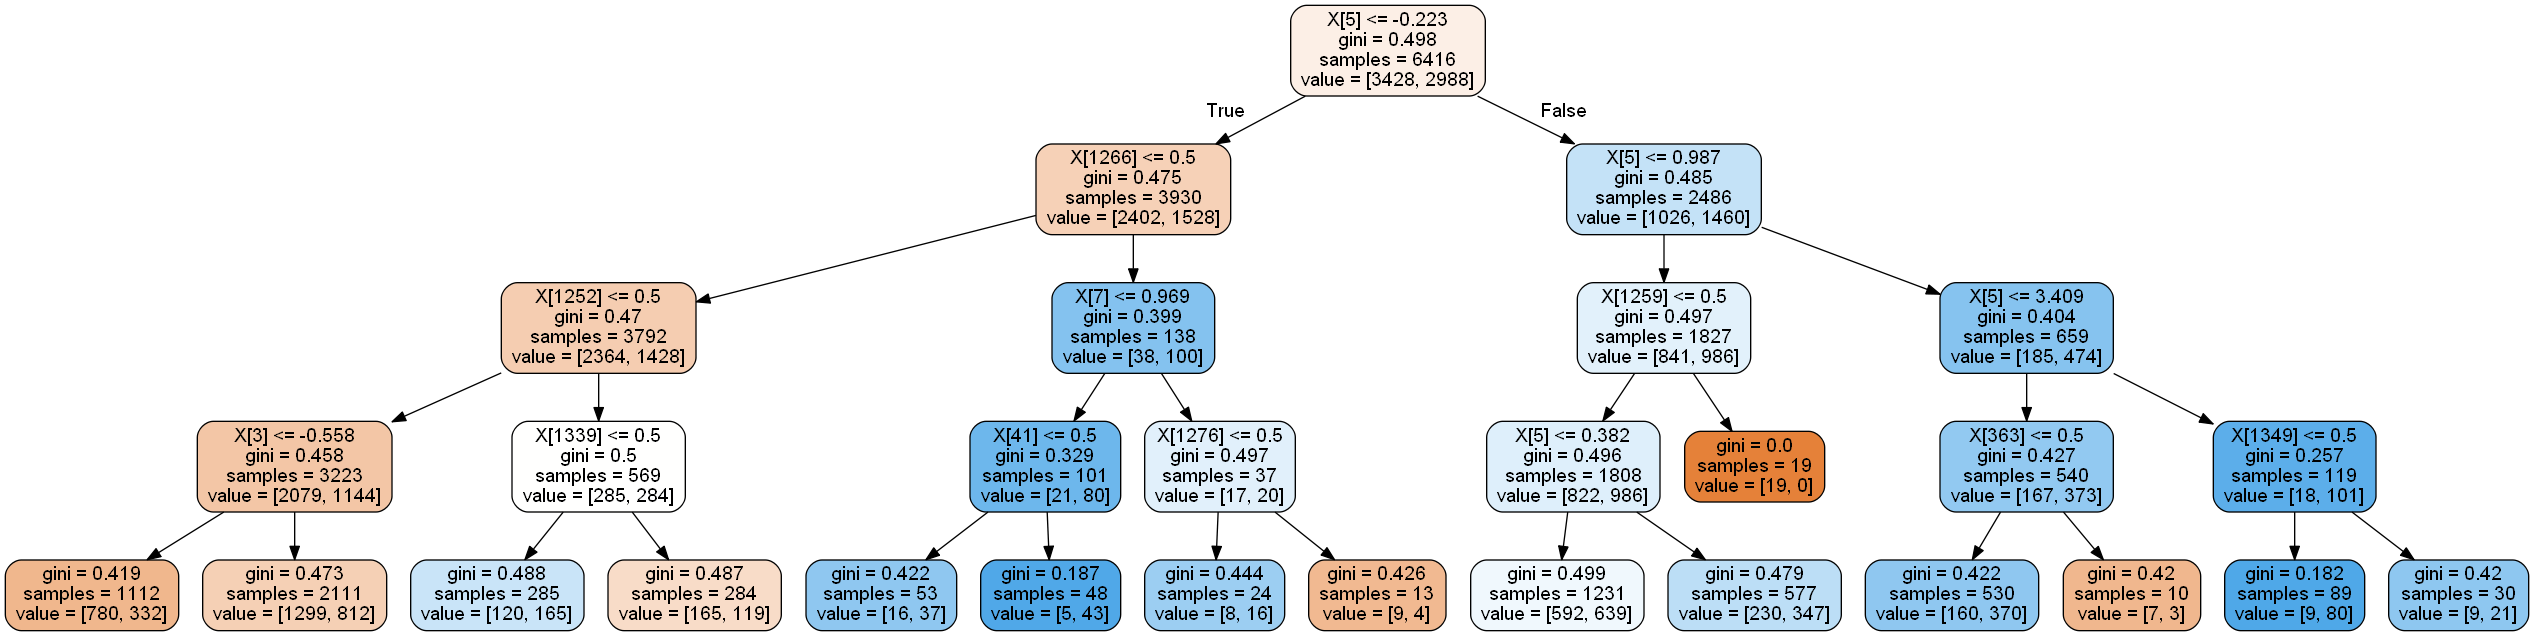

In [65]:
pydot_graph = pydotplus.graph_from_dot_file("tree.dot2")

Image(pydot_graph.create_png())

The grid search selected max_depth= 4, min_samples_leaf= 9; however, it failed to improve on the first model, reaching only 61.0% test accuracy.